In [1]:
import pickle, networkx as nx

with open("graph_out/graph.pkl", "rb") as fp:
    G = pickle.load(fp)

print("노드:", G.number_of_nodes())
print("엣지:", G.number_of_edges())

# 상위 10개 전이와 빈도
top10 = sorted(G.edges(data=True, keys=True),
               key=lambda x: x[3]["count"], reverse=True)[:10]
for u, v, act, data in top10:
    print(f"{act:15}  {data['count']:4}  {u[:6]}… -> {v[:6]}…")


노드: 27
엣지: 78
goodbye             8  1877d4… -> 1877d4…
inform(slot)        6  1877d4… -> 1877d4…
request(day)        4  1877d4… -> 1877d4…
request(slot)       4  1877d4… -> 1877d4…
request(area)       3  1877d4… -> 1877d4…
request(price)      3  1877d4… -> 1877d4…
offer(slot_set)     2  1877d4… -> 1877d4…
book(slot_set)      2  1877d4… -> 1877d4…
inform(area|price)     2  1877d4… -> 1877d4…
greet               2  1877d4… -> 1877d4…


노드 27, 엣지 78
코어 서브그래프: 노드 27, 엣지 78


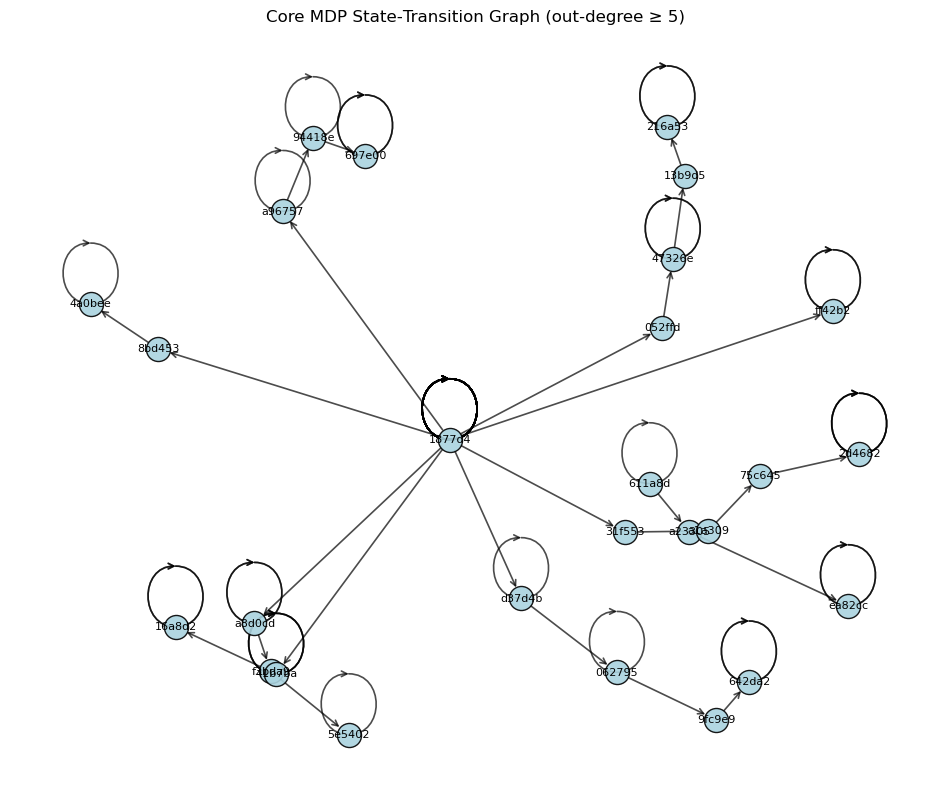

In [4]:
# --- 1. 라이브러리 불러오기 ---
import pickle, random
import networkx as nx
import matplotlib.pyplot as plt

# --- 2. 그래프 로드 ---
with open("graph_out/graph.pkl", "rb") as fp:
    G = pickle.load(fp)

print(f"노드 {G.number_of_nodes()}, 엣지 {G.number_of_edges()}")

# --- 3. (선택) 너무 크면 일부만 추출 ---
#   out‑degree 5 이상 노드만 추출 → 핵심 전이 위주로 보기
core_nodes = [n for n,d in G.out_degree()]
H = G.subgraph(core_nodes).copy()

print(f"코어 서브그래프: 노드 {H.number_of_nodes()}, 엣지 {H.number_of_edges()}")

# --- 4. 레이아웃 계산 (spring 이 가장 직관적) ---
pos = nx.spring_layout(H, k=0.3, seed=42)

# --- 5. 시각화 ---
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(H, pos,
                       node_size=300,
                       node_color="#AAD3DF",
                       alpha=0.9,
                       edgecolors="k")
nx.draw_networkx_edges(H, pos,
                       arrowstyle="->",
                       arrowsize=10,
                       width=1.2,
                       alpha=0.7)
# 노드 라벨: state_id 앞 6글자만 줄여서 표시
short_labels = {n: n[:6] for n in H.nodes()}
nx.draw_networkx_labels(H, pos,
                        labels=short_labels,
                        font_size=8)

plt.axis("off")
plt.title("Core MDP State‑Transition Graph (out‑degree ≥ 5)")
plt.show()


노드 84, 엣지 208
코어 서브그래프: 노드 84, 엣지 208


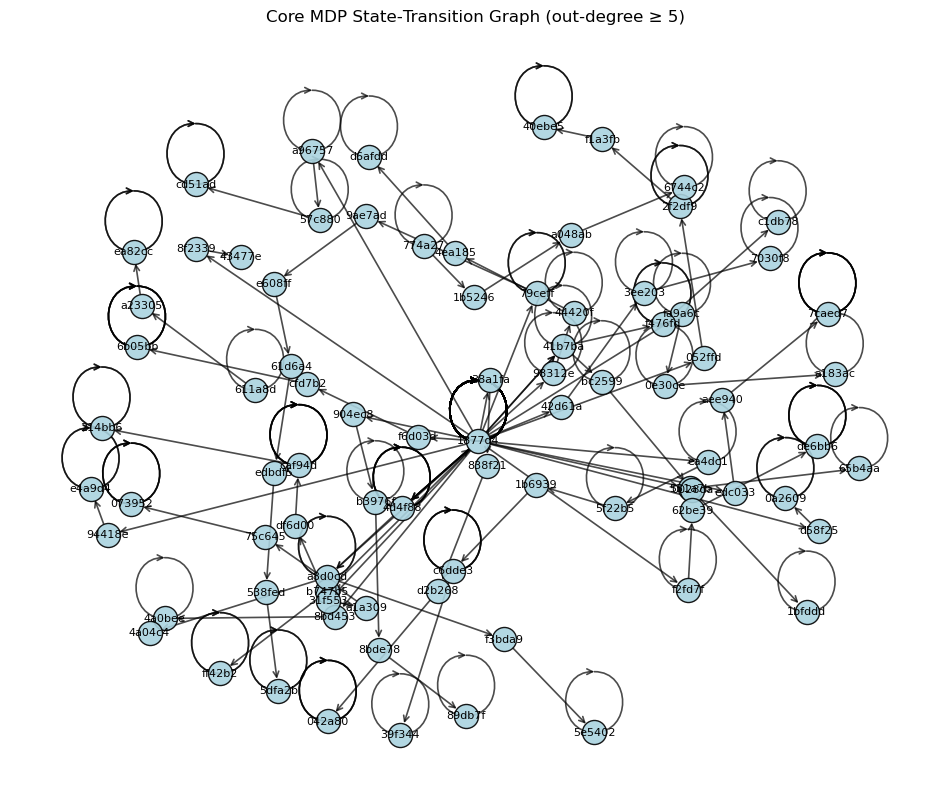

In [7]:
with open("graph_out2/graph.pkl", "rb") as fp:
    G = pickle.load(fp)
# --- 1. 라이브러리 불러오기 ---
import pickle, random
import networkx as nx
import matplotlib.pyplot as plt


print(f"노드 {G.number_of_nodes()}, 엣지 {G.number_of_edges()}")

# --- 3. (선택) 너무 크면 일부만 추출 ---
#   out‑degree 5 이상 노드만 추출 → 핵심 전이 위주로 보기
core_nodes = [n for n,d in G.out_degree()]
H = G.subgraph(core_nodes).copy()

print(f"코어 서브그래프: 노드 {H.number_of_nodes()}, 엣지 {H.number_of_edges()}")

# --- 4. 레이아웃 계산 (spring 이 가장 직관적) ---
pos = nx.spring_layout(H, k=0.3, seed=42)

# --- 5. 시각화 ---
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(H, pos,
                       node_size=300,
                       node_color="#AAD3DF",
                       alpha=0.9,
                       edgecolors="k")
nx.draw_networkx_edges(H, pos,
                       arrowstyle="->",
                       arrowsize=10,
                       width=1.2,
                       alpha=0.7)
# 노드 라벨: state_id 앞 6글자만 줄여서 표시
short_labels = {n: n[:6] for n in H.nodes()}
nx.draw_networkx_labels(H, pos,
                        labels=short_labels,
                        font_size=8)

plt.axis("off")
plt.title("Core MDP State‑Transition Graph (out‑degree ≥ 5)")
plt.show()


Loaded: 84 nodes, 208 edges
Root: 1877d4c1 …
Tree: 77 nodes, 76 edges


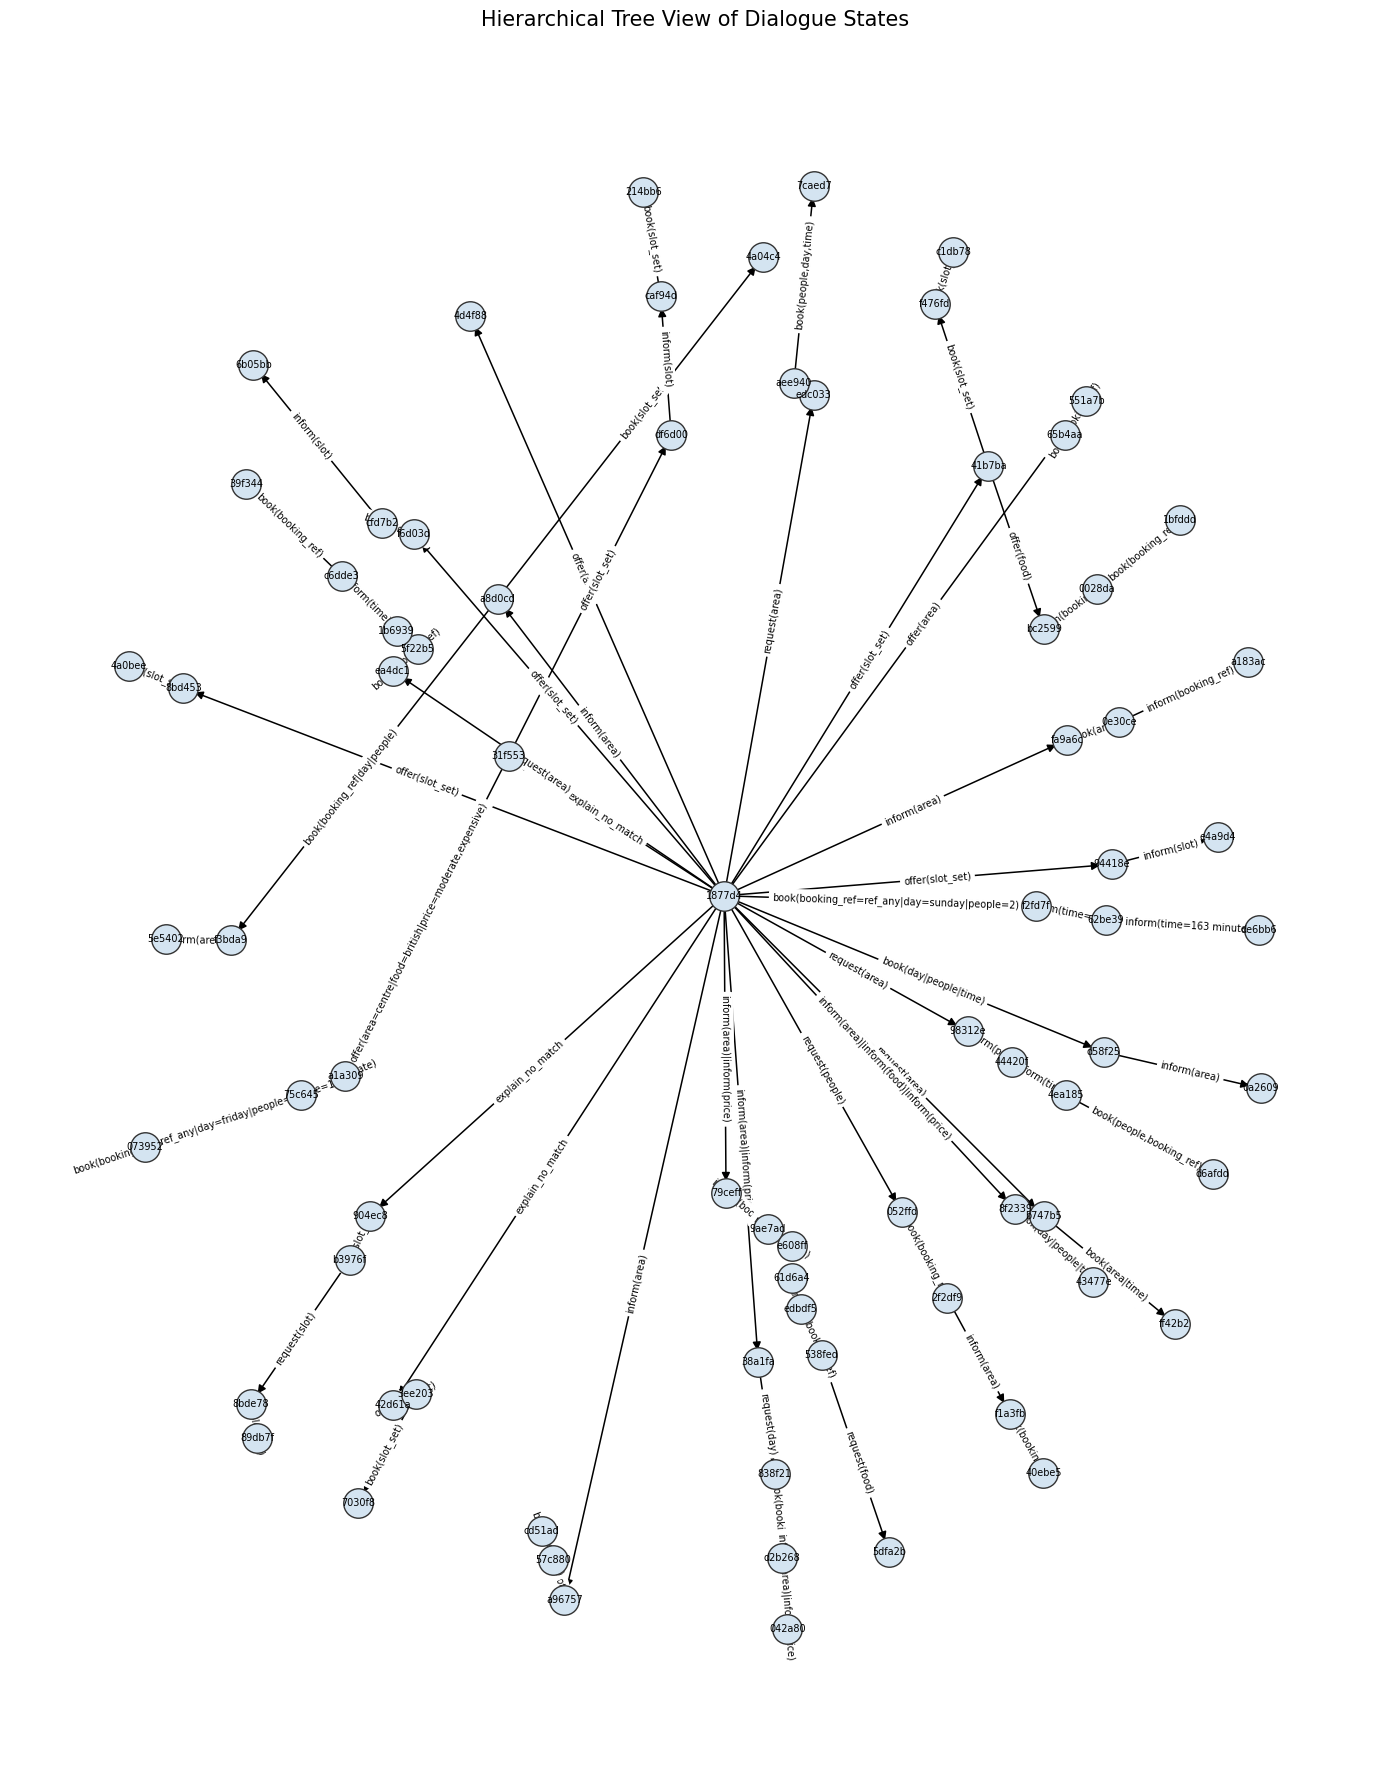

In [10]:
# ---------------------------------------------
# 0. 라이브러리
# ---------------------------------------------
import pickle, networkx as nx, matplotlib.pyplot as plt

# ---------------------------------------------
# 1. 그래프 로드
# ---------------------------------------------
with open("graph_out2/graph.pkl", "rb") as fp:
    G = pickle.load(fp)

print(f"Loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ---------------------------------------------
# 2. 루트 노드 선택
# ---------------------------------------------
ROOT_STATE = "area=none|price=none|food=none|people=none|day=none|time=none|booking_ref=none"

def find_root(graph):
    # state_repr 가 있을 때 none 슬롯이 가장 많은 노드
    for n, d in graph.nodes(data=True):
        if d.get("state_repr") == ROOT_STATE:
            return n
    if "state_repr" in next(iter(graph.nodes(data=True)))[1]:
        return max(graph.nodes, key=lambda n: graph.nodes[n]["state_repr"].count("=none"))
    return max(graph.nodes, key=graph.out_degree)

root_id = find_root(G)
print("Root:", root_id[:8], "…")

# ---------------------------------------------
# 3. BFS 스패닝 트리 (수정된 루프)
# ---------------------------------------------
T = nx.DiGraph()
for u, v in nx.bfs_edges(G, source=root_id):
    # u→v 사이 첫 번째 action key 가져오기
    action_key = next(iter(G[u][v]))
    T.add_edge(u, v, action=action_key)

print("Tree:", T.number_of_nodes(), "nodes,", T.number_of_edges(), "edges")

# ---------------------------------------------
# 4. 계층 레이아웃
# ---------------------------------------------
try:
    pos = nx.nx_agraph.graphviz_layout(T, prog="dot")   # 위→아래
except:
    pos = nx.spring_layout(T, seed=1)                   # 그래프비즈 없을 때

# ---------------------------------------------
# 5. 시각화
# ---------------------------------------------
plt.figure(figsize=(14, 18))
nx.draw_networkx_nodes(T, pos, node_size=450,
                       node_color="#D4E4F1", edgecolors="#333")

# 노드 라벨: state_repr 있으면 표시, 없으면 해시 앞 6글자
node_labels = {
    n: (G.nodes[n].get("state_repr") or n[:6])
    for n in T.nodes()
}
nx.draw_networkx_labels(T, pos, labels=node_labels, font_size=7)

edge_labels = {(u, v): d["action"] for u, v, d in T.edges(data=True)}
nx.draw_networkx_edges(T, pos, arrowsize=12, width=1.1)
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels,
                             font_size=7, label_pos=0.45)

plt.axis("off")
plt.title("Hierarchical Tree View of Dialogue States", fontsize=15)
plt.tight_layout()
plt.show()
